<a href="https://colab.research.google.com/github/lokeshcv/ComputerVisionDeepLearning/blob/main/pytorch_vision_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchinfo

In [2]:
import torch
import torch.nn as nn
from torch.utils import data
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchinfo import summary

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import glob
import os
import zipfile

Resuable Functions

In [3]:
default_device = 'cuda' if torch.cuda.is_available() else 'cpu'

def load_mnist(batch_size=64):
    data_train = torchvision.datasets.MNIST('./data',
        download=True,train=True,transform=ToTensor())
    data_test = torchvision.datasets.MNIST('./data',
        download=True,train=False,transform=ToTensor())
    train_loader = torch.utils.data.DataLoader(data_train,batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(data_test,batch_size=batch_size)

    return data_train, data_test, train_loader, test_loader

def train_epoch(net,dataloader,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    net.train()
    total_loss,acc,count = 0,0,0
    for features,labels in dataloader:
        optimizer.zero_grad()
        lbls = labels.to(default_device)
        out = net(features.to(default_device))
        loss = loss_fn(out,lbls) #cross_entropy(out,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc+=(predicted==lbls).sum()
        count+=len(labels)
    return total_loss.item()/count, acc.item()/count

def validate(net, dataloader,loss_fn=nn.NLLLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            lbls = labels.to(default_device)
            out = net(features.to(default_device))
            loss += loss_fn(out,lbls)
            pred = torch.max(out,1)[1]
            acc += (pred==lbls).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

def train(net,train_loader,test_loader,optimizer=None,lr=0.01,epochs=10,loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn)
        vl,va = validate(net,test_loader,loss_fn=loss_fn)
        print(f"Epoch {ep+1:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

def train_long(net,train_loader,test_loader,epochs=5,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss(),print_freq=10):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    for epoch in range(epochs):
        net.train()
        total_loss,acc,count = 0,0,0
        for i, (features,labels) in enumerate(train_loader):
            lbls = labels.to(default_device)
            optimizer.zero_grad()
            out = net(features.to(default_device))
            loss = loss_fn(out,lbls)
            loss.backward()
            optimizer.step()
            total_loss+=loss
            _,predicted = torch.max(out,1)
            acc+=(predicted==lbls).sum()
            count+=len(labels)
            if i%print_freq==0:
                print("Epoch {}, minibatch {}: train acc = {}, train loss = {}".format(epoch,i,acc.item()/count,total_loss.item()/count))
        vl,va = validate(net,test_loader,loss_fn)
        print("Epoch {} done, validation acc = {}, validation loss = {}".format(epoch,va,vl))


def plot_results(hist):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(hist['train_acc'], label='Training acc')
    plt.plot(hist['val_acc'], label='Validation acc')
    plt.legend()
    plt.subplot(122)
    plt.plot(hist['train_loss'], label='Training loss')
    plt.plot(hist['val_loss'], label='Validation loss')
    plt.legend()

def plot_convolution(data_train, t,title=''):
    with torch.no_grad():
        c = nn.Conv2d(kernel_size=(3,3),out_channels=1,in_channels=1)
        c.weight.copy_(t)
        fig, ax = plt.subplots(2,6,figsize=(8,3))
        fig.suptitle(title,fontsize=16)
        for i in range(5):
            im = data_train[i][0]
            ax[0][i].imshow(im[0], cmap='gray')
            ax[1][i].imshow(c(im.unsqueeze(0))[0][0], cmap='gray')
            ax[0][i].axis('off')
            ax[1][i].axis('off')
        ax[0,5].imshow(t)#, cmap='gray')
        ax[0,5].axis('off')
        ax[1,5].axis('off')
        #plt.tight_layout()
        plt.show()

def display_dataset(dataset, n=10,classes=None):
    fig,ax = plt.subplots(1,n,figsize=(15,3))
    mn = min([dataset[i][0].min() for i in range(n)])
    mx = max([dataset[i][0].max() for i in range(n)])
    for i in range(n):
        ax[i].imshow(np.transpose((dataset[i][0]-mn)/(mx-mn),(1,2,0)))
        ax[i].axis('off')
        if classes:
            ax[i].set_title(classes[dataset[i][1]])


def check_image(fn):
    try:
        im = Image.open(fn)
        im.verify()
        return True
    except:
        return False

def check_image_dir(path):
    for fn in glob.glob(path):
        if not check_image(fn):
            print("Corrupt image: {}".format(fn))
            os.remove(fn)


def common_transform():
    std_normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
    trans = torchvision.transforms.Compose([
            torchvision.transforms.Resize(256),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(),
            std_normalize])
    return trans

def load_cats_dogs_dataset():
    if not os.path.exists('data/PetImages'):
        with zipfile.ZipFile('data/kagglecatsanddogs_5340.zip', 'r') as zip_ref:
            zip_ref.extractall('data')

    check_image_dir('data/PetImages/Cat/*.jpg')
    check_image_dir('data/PetImages/Dog/*.jpg')

    dataset = torchvision.datasets.ImageFolder('data/PetImages',transform=common_transform())
    trainset, testset = torch.utils.data.random_split(dataset,[20000,len(dataset)-20000])
    trainloader = torch.utils.data.DataLoader(trainset,batch_size=32)
    testloader = torch.utils.data.DataLoader(trainset,batch_size=32)
    return dataset, trainloader, testloader

In [4]:
train_ds, test_ds, train_loader, test_loader = load_mnist(batch_size=128)

100%|██████████| 9912422/9912422 [00:00<00:00, 196139601.10it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 94859587.96it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 60894871.02it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5322863.58it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Convolutional filters are small windows that run over each pixel of the image and compute weighted average of the neighboring pixels.

They are defined by matrices of weight coefficients. Let's see the examples of applying two different convolutional filters over our MNIST handwritten digits:

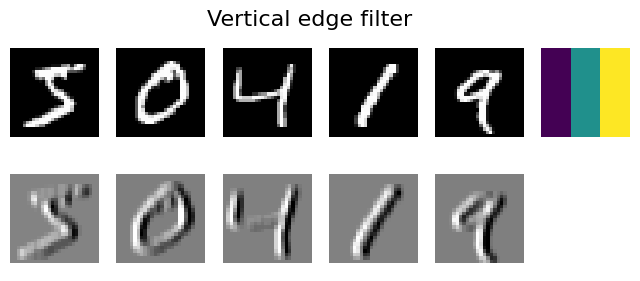

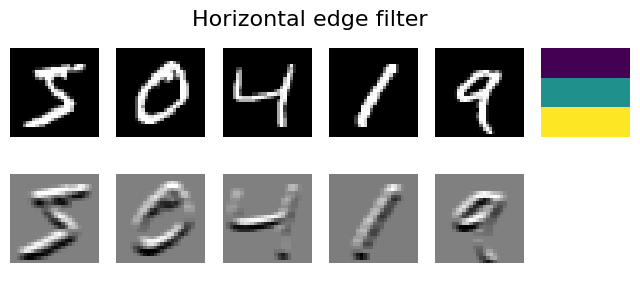

In [5]:
plot_convolution(train_ds,
                 torch.tensor([[-1.,0.,1.],[-1.,0.,1.],[-1.,0.,1.]]),
                 'Vertical edge filter')
plot_convolution(train_ds,
                 torch.tensor([[-1.,-1.,-1.],[0.,0.,0.],[1.,1.,1.]]),
                 'Horizontal edge filter')

In classical computer vision, multiple filters were applied to the image to generate features, which then were used by machine learning algorithm to build a classifier. However, in deep learning we construct networks that learn best convolutional filters to solve classification problem.

To do that, we introduce convolutional layers.

### Covolutional layers

Convolutional layers are defined using nn.Conv2d construction

In [6]:
class OneConv(nn.Module):

  def __init__(self):
    super(OneConv, self).__init__()
    self.conv = nn.Conv2d(in_channels=1,out_channels=8,kernel_size=(5,5))
    self.flatten = nn.Flatten()
    self.fc = nn.Linear(4608 , 10)

  def forward(self, x):
    x = self.conv(x)
    x = nn.functional.relu(x)
    x = self.flatten(x)
    x = self.fc(x)
    x = nn.functional.log_softmax(x, dim=1)
    return x

net= OneConv()
summary(net, input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
OneConv                                  [1, 10]                   --
├─Conv2d: 1-1                            [1, 8, 24, 24]            208
├─Flatten: 1-2                           [1, 4608]                 --
├─Linear: 1-3                            [1, 10]                   46,090
Total params: 46,298
Trainable params: 46,298
Non-trainable params: 0
Total mult-adds (M): 0.17
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.19
Estimated Total Size (MB): 0.23

Epoch  1, Train acc=0.942, Val acc=0.966, Train loss=0.001, Val loss=0.001
Epoch  2, Train acc=0.977, Val acc=0.973, Train loss=0.001, Val loss=0.001
Epoch  3, Train acc=0.983, Val acc=0.977, Train loss=0.000, Val loss=0.001
Epoch  4, Train acc=0.986, Val acc=0.981, Train loss=0.000, Val loss=0.001
Epoch  5, Train acc=0.987, Val acc=0.978, Train loss=0.000, Val loss=0.001


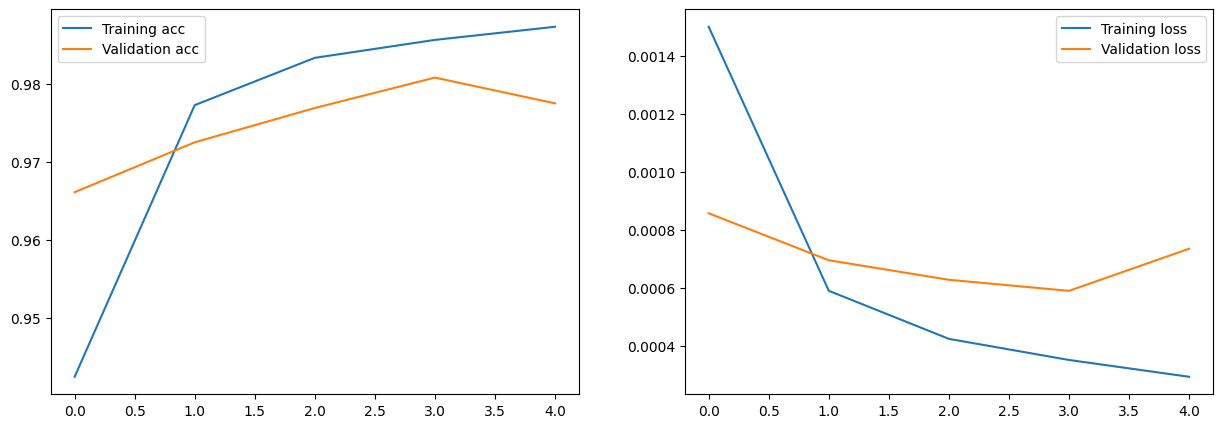

In [7]:
hist = train(net,train_loader,test_loader,epochs=5)
plot_results(hist)

We can also visualize the weights of our trained convolutional layers, to try and make some more sense of what is going on




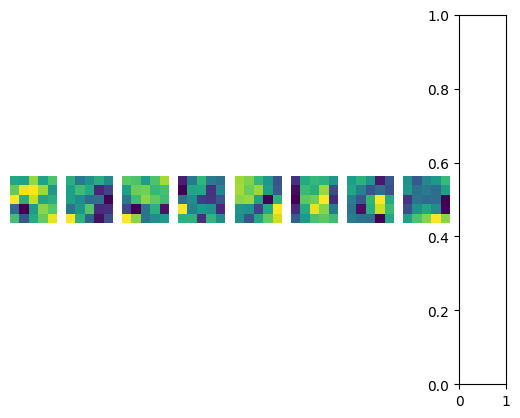

In [8]:
fig,ax = plt.subplots(1,9)
with torch.no_grad():
    p = next(net.conv.parameters())
    for i,x in enumerate(p):
        ax[i].imshow(x.detach().cpu()[0,...])
        ax[i].axis('off')

### Multi-Layered CNNs

 To recognize  patterns, we can add multiple layer of convolution filters on top of the result of the first layer.

#### Pooling layers


1.  **Average Pooling** takes a sliding window (for example, 2x2 pixels) and computes an average of values within the window

2.   **Max Pooling** replaces the window with the maximum value. The idea behind max pooling is to detect a presence of a certain pattern within the sliding window.

Thus, in a typical CNN there would be composed of several convolutional layers, with pooling layers in between them to decrease dimensions of the image. We would also increase the number of filters, because as patterns become more advanced - there are more possible interesting combinations that we need to be looking for.

Instead of using Flatten layer, we are flattening the tensor inside forward function using view function, which is similar to reshape function in numpy

In [9]:
class MultiLayerCNN(nn.Module):
    def __init__(self):
        super(MultiLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc = nn.Linear(320,10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 320)
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x

net = MultiLayerCNN()
summary(net,input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
MultiLayerCNN                            [1, 10]                   --
├─Conv2d: 1-1                            [1, 10, 24, 24]           260
├─MaxPool2d: 1-2                         [1, 10, 12, 12]           --
├─Conv2d: 1-3                            [1, 20, 8, 8]             5,020
├─MaxPool2d: 1-4                         [1, 20, 4, 4]             --
├─Linear: 1-5                            [1, 10]                   3,210
Total params: 8,490
Trainable params: 8,490
Non-trainable params: 0
Total mult-adds (M): 0.47
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.03
Estimated Total Size (MB): 0.09

In [10]:
hist = train(net,train_loader,test_loader,epochs=5)

Epoch  1, Train acc=0.950, Val acc=0.970, Train loss=0.001, Val loss=0.001
Epoch  2, Train acc=0.983, Val acc=0.985, Train loss=0.000, Val loss=0.000
Epoch  3, Train acc=0.986, Val acc=0.985, Train loss=0.000, Val loss=0.000
Epoch  4, Train acc=0.987, Val acc=0.982, Train loss=0.000, Val loss=0.000
Epoch  5, Train acc=0.988, Val acc=0.981, Train loss=0.000, Val loss=0.001


### CIFAR-10 dataset

In [11]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='/content/data',
                                        train=True, download=True,
                                        transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=14,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='/content/data',
                                       train=False,
                                       download=True,
                                       transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=14,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog',
           'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:05<00:00, 29189174.74it/s]


Extracting /content/data/cifar-10-python.tar.gz to /content/data
Files already downloaded and verified


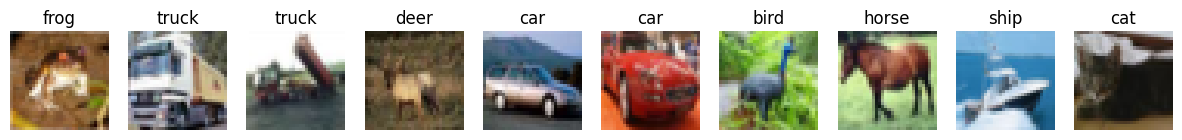

In [12]:
display_dataset(trainset,classes=classes)

A well-known architecture for CIFAR-10 is called LeNet,

In [13]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16,120,5)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(120,64)
        self.fc2 = nn.Linear(64,10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = self.flat(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = LeNet()

summary(net,input_size=(1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─MaxPool2d: 1-2                         [1, 6, 14, 14]            --
├─Conv2d: 1-3                            [1, 16, 10, 10]           2,416
├─MaxPool2d: 1-4                         [1, 16, 5, 5]             --
├─Conv2d: 1-5                            [1, 120, 1, 1]            48,120
├─Flatten: 1-6                           [1, 120]                  --
├─Linear: 1-7                            [1, 64]                   7,744
├─Linear: 1-8                            [1, 10]                   650
Total params: 59,386
Trainable params: 59,386
Non-trainable params: 0
Total mult-adds (M): 0.66
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.30

We also do one more simplification to this model - we do not use log_softmax as output activation function, and just return the output of last fully-connected layer. In this case we can just use CrossEntropyLoss loss function to optimize the model.

In [14]:
opt = torch.optim.SGD(net.parameters(),lr=0.001,momentum=0.9)
hist = train(net, trainloader,
             testloader,
             epochs=5, optimizer=opt,
             loss_fn=nn.CrossEntropyLoss())

Epoch  1, Train acc=0.240, Val acc=0.379, Train loss=0.146, Val loss=0.121
Epoch  2, Train acc=0.422, Val acc=0.470, Train loss=0.112, Val loss=0.103
Epoch  3, Train acc=0.495, Val acc=0.508, Train loss=0.099, Val loss=0.097
Epoch  4, Train acc=0.544, Val acc=0.549, Train loss=0.091, Val loss=0.090
Epoch  5, Train acc=0.580, Val acc=0.586, Train loss=0.084, Val loss=0.083


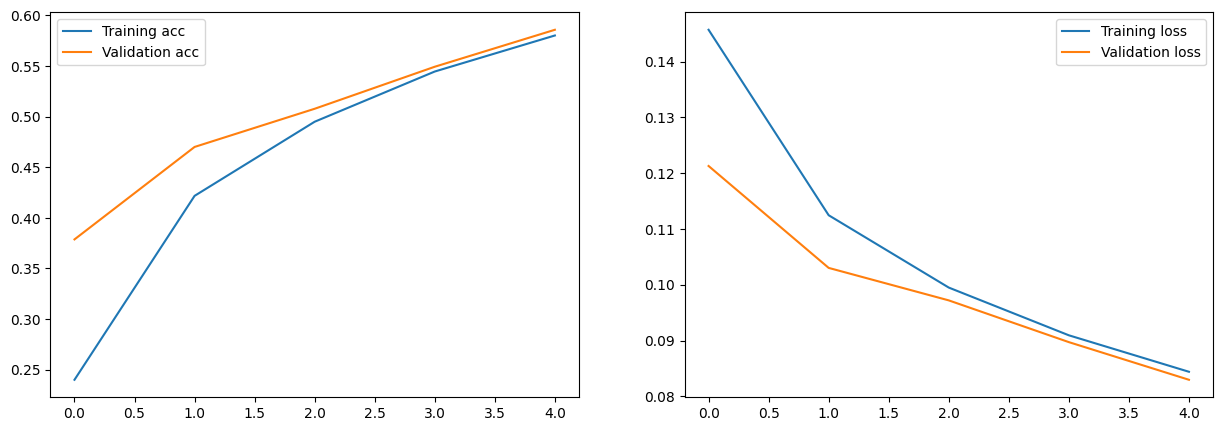

In [15]:
plot_results(hist)

In [16]:
if not os.path.exists('data/kagglecatsanddogs_5340.zip'):
    !wget -P data -q https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

In [17]:
import zipfile
if not os.path.exists('data/PetImages'):
    with zipfile.ZipFile('data/kagglecatsanddogs_5340.zip', 'r') as zip_ref:
        zip_ref.extractall('data')

In [18]:
check_image_dir('data/PetImages/Cat/*.jpg')
check_image_dir('data/PetImages/Dog/*.jpg')

Corrupt image: data/PetImages/Cat/666.jpg


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Corrupt image: data/PetImages/Dog/11702.jpg


In [19]:
std_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std = [0.229, 0.224, 0.225])

In [20]:
pipeline_tran = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    std_normalize])

In [21]:
pet_ds = torchvision.datasets.ImageFolder('data/PetImages', transform= pipeline_tran)
pet_train_ds, pet_test_ds = torch.utils.data.random_split(pet_ds, [20000, len(pet_ds) - 20000])


In [22]:
display(pet_ds)

Dataset ImageFolder
    Number of datapoints: 24998
    Root location: data/PetImages
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [23]:
# Download model weights in the sandbox environment
!mkdir -p models
!wget -P models https://github.com/MicrosoftDocs/pytorchfundamentals/raw/main/computer-vision-pytorch/vgg16-397923af.pth

--2023-08-22 12:37:10--  https://github.com/MicrosoftDocs/pytorchfundamentals/raw/main/computer-vision-pytorch/vgg16-397923af.pth
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/vgg16-397923af.pth [following]
--2023-08-22 12:37:10--  https://media.githubusercontent.com/media/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/vgg16-397923af.pth
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553433881 (528M) [application/octet-stream]
Saving to: ‘models/vgg16-397923af.pth’

vgg16-397923af.pth  100%[========

The result that we have received is a number of an ImageNet class

In [24]:
file_path = 'models/vgg16-397923af.pth'

vgg = torchvision.models.vgg16()
vgg.load_state_dict(torch.load(file_path))
vgg.eval()

sample_image = pet_ds[0][0].unsqueeze(0)
res = vgg(sample_image)
print(res[0].argmax())

tensor(282)


In [25]:
import json, requests
class_map = json.loads(requests.get("https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/imagenet_class_index.json").text)
class_map = { int(k) : v for k,v in class_map.items() }

class_map[res[0].argmax().item()]

['n02123159', 'tiger_cat']

In [26]:
summary(vgg,input_size=(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

In [27]:
print('Doing computations on device = {}'.format(default_device))

vgg.to(default_device)
sample_image = sample_image.to(default_device)

vgg(sample_image).argmax()

Doing computations on device = cuda


tensor(282, device='cuda:0')

### Extract VGG Features

torch.Size([1, 512, 7, 7])


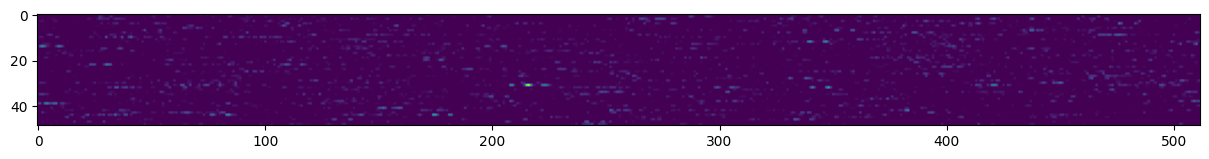

In [28]:
res = vgg.features(sample_image).cpu()
plt.figure(figsize=(15,3))
plt.imshow(res.detach().view(-1,512))
print(res.size())

Now we can define vgg_dataset that takes data from this tensor, split it into training and test sets using random_split function, and train a small one-layer dense classifier network on top of extracted features:

In [29]:
bs = 8
dl = torch.utils.data.DataLoader(pet_ds,batch_size=bs,shuffle=True)
num = bs*100
feature_tensor = torch.zeros(num,512*7*7).to(default_device)
label_tensor = torch.zeros(num).to(default_device)
i = 0
for x,l in dl:
    with torch.no_grad():
        f = vgg.features(x.to(default_device))
        feature_tensor[i:i+bs] = f.view(bs,-1)
        label_tensor[i:i+bs] = l
        i+=bs
        print('.',end='')
        if i>=num:
            break


....................................................................................................

In [30]:
vgg_dataset = torch.utils.data.TensorDataset(feature_tensor,label_tensor.to(torch.long))
train_ds, test_ds = torch.utils.data.random_split(vgg_dataset,[700,100])

train_loader = torch.utils.data.DataLoader(train_ds,batch_size=32)
test_loader = torch.utils.data.DataLoader(test_ds,batch_size=32)

net = torch.nn.Sequential(torch.nn.Linear(512*7*7,2),torch.nn.LogSoftmax()).to(default_device)

history = train(net,train_loader,test_loader)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch  1, Train acc=0.910, Val acc=0.990, Train loss=0.074, Val loss=0.002
Epoch  2, Train acc=0.980, Val acc=0.960, Train loss=0.021, Val loss=0.031
Epoch  3, Train acc=0.974, Val acc=0.980, Train loss=0.036, Val loss=0.006
Epoch  4, Train acc=0.993, Val acc=0.970, Train loss=0.006, Val loss=0.012
Epoch  5, Train acc=0.999, Val acc=0.990, Train loss=0.001, Val loss=0.005
Epoch  6, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.003
Epoch  7, Train acc=1.000, Val acc=0.980, Train loss=0.000, Val loss=0.006
Epoch  8, Train acc=1.000, Val acc=0.980, Train loss=0.000, Val loss=0.006
Epoch  9, Train acc=1.000, Val acc=0.980, Train loss=0.000, Val loss=0.006
Epoch 10, Train acc=1.000, Val acc=0.980, Train loss=0.000, Val loss=0.006


### Transfer Learning Using One VGG

In [31]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1


Network contains
1.   Feature Extractor (features) - Convolution and Pooling Layers
2.   Average Pooling Layer
3.   Final Classifier - Dense Layer to 1000 classes



1.   For Classification of the Cat and Dog - Replace the final classifier layer to have dense layer with 2 output neurons
2.   Freeze the weights of the Convolution Layers - Set requires_grad to False

In [32]:
vgg.classifier = torch.nn.Linear(25088,2).to(default_device)

for x in vgg.features.parameters():
    x.requires_grad = False

summary(vgg,(1, 3,244,244))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 2]                    --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 244, 244]         (1,792)
│    └─ReLU: 2-2                         [1, 64, 244, 244]         --
│    └─Conv2d: 2-3                       [1, 64, 244, 244]         (36,928)
│    └─ReLU: 2-4                         [1, 64, 244, 244]         --
│    └─MaxPool2d: 2-5                    [1, 64, 122, 122]         --
│    └─Conv2d: 2-6                       [1, 128, 122, 122]        (73,856)
│    └─ReLU: 2-7                         [1, 128, 122, 122]        --
│    └─Conv2d: 2-8                       [1, 128, 122, 122]        (147,584)
│    └─ReLU: 2-9                         [1, 128, 122, 122]        --
│    └─MaxPool2d: 2-10                   [1, 128, 61, 61]          --
│    └─Conv2d: 2-11                      [1, 256, 61, 61]    

Since we frooze the Conv2D layers, so only 50k trainable parameters of the final classification layer

In [33]:
trainset, testset = torch.utils.data.random_split(pet_ds,[20000,len(pet_ds)-20000])
train_loader = torch.utils.data.DataLoader(trainset,batch_size=16)
test_loader = torch.utils.data.DataLoader(testset,batch_size=16)

train_long(vgg,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90)

Epoch 0, minibatch 0: train acc = 0.4375, train loss = 0.04845321178436279
Epoch 0, minibatch 90: train acc = 0.9429945054945055, train loss = 0.14673155480688746
Epoch 0, minibatch 180: train acc = 0.9499309392265194, train loss = 0.15474161390441557
Epoch 0, minibatch 270: train acc = 0.9534132841328413, train loss = 0.14925119885659305
Epoch 0, minibatch 360: train acc = 0.9584487534626038, train loss = 0.1408307506106897
Epoch 0, minibatch 450: train acc = 0.9611973392461197, train loss = 0.13723578104158726
Epoch 0, minibatch 540: train acc = 0.9640711645101664, train loss = 0.13443842128112002
Epoch 0, minibatch 630: train acc = 0.965729001584786, train loss = 0.1371549675846251
Epoch 0, minibatch 720: train acc = 0.9662794729542302, train loss = 0.14200841768770045
Epoch 0, minibatch 810: train acc = 0.967170160295931, train loss = 0.1413975632146607
Epoch 0, minibatch 900: train acc = 0.969062153163152, train loss = 0.13409107136276532
Epoch 0, minibatch 990: train acc = 0.9697

In [34]:
torch.save(vgg,'data/cats_dogs.pth')
#vgg = torch.load('data/catsPdogs.pth')

### Fine Tuning Transfer Learning

Unfreeze the Convolutional Layers

In [35]:
for lyr in vgg.features.parameters():
  lyr.requires_grad=True

In [36]:
train_long(vgg,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90,lr=0.0001)

Epoch 0, minibatch 0: train acc = 1.0, train loss = 0.0
Epoch 0, minibatch 90: train acc = 0.9381868131868132, train loss = 0.1693342334621555
Epoch 0, minibatch 180: train acc = 0.9437154696132597, train loss = 0.10656679269358597
Epoch 0, minibatch 270: train acc = 0.9437269372693727, train loss = 0.07838023280745503
Epoch 0, minibatch 360: train acc = 0.942174515235457, train loss = 0.06346592678587852
Epoch 0, minibatch 450: train acc = 0.9480321507760532, train loss = 0.052067538851380615
Epoch 0, minibatch 540: train acc = 0.9505545286506469, train loss = 0.045300644118331936
Epoch 0, minibatch 630: train acc = 0.9500792393026941, train loss = 0.040323420674222774
Epoch 0, minibatch 720: train acc = 0.9523231622746186, train loss = 0.036432181581875486
Epoch 0, minibatch 810: train acc = 0.9534525277435265, train loss = 0.033279287241831074
Epoch 0, minibatch 900: train acc = 0.9551886792452831, train loss = 0.030462887390339942
Epoch 0, minibatch 990: train acc = 0.9567356205852

### MobileNet - Light weight networks

In [37]:
model = torch.hub.load('pytorch/vision:v0.13.0', 'mobilenet_v2', weights='MobileNet_V2_Weights.DEFAULT')
model.eval()
print(model)

Downloading: "https://github.com/pytorch/vision/zipball/v0.13.0" to /root/.cache/torch/hub/v0.13.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 35.7MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

ImageNet - Classes
https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

In [38]:
sample_image = pet_ds[0][0].unsqueeze(0)
res = model(sample_image)
print(res[0].argmax())

tensor(186)


### Transfer Learning with MobileNet

Freeze the parameters

In [39]:
for lyr in model.parameters():
  lyr.requires_grad=False

Update the final classifier to classifier two classes

In [40]:
model.classifier = nn.Linear(1280,2)
model = model.to(default_device)
summary(model,input_size=(1,3,244,244))

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV2                                        [1, 2]                    --
├─Sequential: 1-1                                  [1, 1280, 8, 8]           --
│    └─Conv2dNormActivation: 2-1                   [1, 32, 122, 122]         --
│    │    └─Conv2d: 3-1                            [1, 32, 122, 122]         (864)
│    │    └─BatchNorm2d: 3-2                       [1, 32, 122, 122]         (64)
│    │    └─ReLU6: 3-3                             [1, 32, 122, 122]         --
│    └─InvertedResidual: 2-2                       [1, 16, 122, 122]         --
│    │    └─Sequential: 3-4                        [1, 16, 122, 122]         (896)
│    └─InvertedResidual: 2-3                       [1, 24, 61, 61]           --
│    │    └─Sequential: 3-5                        [1, 24, 61, 61]           (5,136)
│    └─InvertedResidual: 2-4                       [1, 24, 61, 61]           --
│    │    └─Sequential

In [41]:
train_long(model,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90)

Epoch 0, minibatch 0: train acc = 0.3125, train loss = 0.04580100625753403
Epoch 0, minibatch 90: train acc = 0.8646978021978022, train loss = 0.017976369176592146
Epoch 0, minibatch 180: train acc = 0.8801795580110497, train loss = 0.018479156230694682
Epoch 0, minibatch 270: train acc = 0.8916051660516605, train loss = 0.01760490706046129
Epoch 0, minibatch 360: train acc = 0.9001038781163435, train loss = 0.01729820837934922
Epoch 0, minibatch 450: train acc = 0.9101995565410199, train loss = 0.015781654222577216
Epoch 0, minibatch 540: train acc = 0.9126617375231053, train loss = 0.015368726028752635
Epoch 0, minibatch 630: train acc = 0.9139263074484945, train loss = 0.015449029707870847
Epoch 0, minibatch 720: train acc = 0.9164355062413315, train loss = 0.01511265203129402
Epoch 0, minibatch 810: train acc = 0.9184648581997534, train loss = 0.014826938050595812
Epoch 0, minibatch 900: train acc = 0.9205049944506104, train loss = 0.014419878494990917
Epoch 0, minibatch 990: train

In [44]:
sample_image = pet_ds[0][0].unsqueeze(0).to(default_device)
res = model(sample_image)
print(res[0].argmax())

tensor(0, device='cuda:0')
